In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split  # Import train_test_split function
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree Classifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

import seaborn as sn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
def getOverallAge(birthDates):
    birthYears = []
    for i in birthDates:
        birthYears.append(int(i.split("-")[0]))
    return sum(birthYears) / len(birthYears)


data = pd.read_csv("data/integrated.csv")

label = "playoff"
df = data
df['confID'].value_counts()

df.drop(['pos', 'college'], axis=1, inplace=True)

years = df['year'].unique()
teams = df['tmID'].unique()

for element in ["round", "series", "tmIDWinner", "tmIDLoser", "W_series", "L_series"]:
    df.drop(element, axis=1, inplace=True)
counter = 0
new_df = pd.DataFrame()
for year in years:
    for team in teams:
        small_df = df[(df['tmID'] == team) & (df['year'] == year)]
        if small_df.empty:
            continue
        d = pd.DataFrame([small_df.iloc[0]])
        d.fillna(0, inplace=True)
        d['award_player'] = (small_df['award_player'].count())
        d['award_coach'] = d['award_coach'].apply(lambda x: 1 if x != 0 else 0)
        d['CBE_Sum'] = (small_df['CBE_Sum'].mean())
        d['height'] = (small_df['height'].mean())
        d['weight'] = (small_df['weight'].mean())
        d['playersAge'] = (2000 + df['year']) - getOverallAge(small_df['birthDate'])
        d.drop('playerID', axis=1, inplace=True)
        d.drop('birthDate', axis=1, inplace=True)

        new_df = pd.concat([new_df, d])
        counter += 1

df = new_df
df.sort_values(by=['year', 'tmID'], inplace=True)

if not os.path.exists('data/clean'):
    os.makedirs('data/clean')

df.to_csv('data/clean/miguel.csv', index=False)


In [3]:
df.shape

(122, 66)

In [4]:
mapping = {'L': 'Y',
           'W': 'Y'}

df['semis'] = df['semis'].map(mapping)
df['finals'] = df['finals'].map(mapping)
df['firstRound'] = df['firstRound'].map(mapping)


In [5]:
features = df.columns

X = df[features]
df = X

In [6]:
le = LabelEncoder()
y = le.fit_transform(df['playoff'])
for x in df.columns:
    df[x] = le.fit_transform(df[x])
print(df.iloc[0].values)

[ 0  1  0  0  1  0  7  1  1  1  1  1 38 29 23 22 27 28 26 15 11 60 73 12
 41  7 34 65 38 74 79 23 38 38 24 30 82 13 31  3 31 81  4 19  0  3 11  2
 10  3 13  3  3  4 13  0  5 22  0  0 41 18 30  0  0 43]


In [7]:
available_columns = list(features)
available_columns.remove("playoff")
key_predictors = []
features_values = pd.DataFrame(df, columns=available_columns)
target_values = df["playoff"].values
chi2_results = chi2(features_values, target_values)
best_chi2_cols = SelectKBest(chi2, k=33)

corr_matrix = df.corr()
# fig = plt.figure(figsize=(36,36), dpi = 480)
# sn.heatmap(df.corr(), annot = True, fmt = '.2f')
# plt.show()


key_features = ["playoff", "year", 'confID']

best_chi2_cols.fit(features_values, target_values)

best_chi2_features = features_values.columns[best_chi2_cols.get_support()]
for k in (best_chi2_features):
    key_predictors.append(k)

for ft in key_features:
    if ft not in key_predictors:
        key_predictors.append(ft)
df = df[key_predictors]
key_predictors = list(df.columns)
print(df.shape)


(122, 36)


In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [9]:
print(df['year'].isna().sum())

0


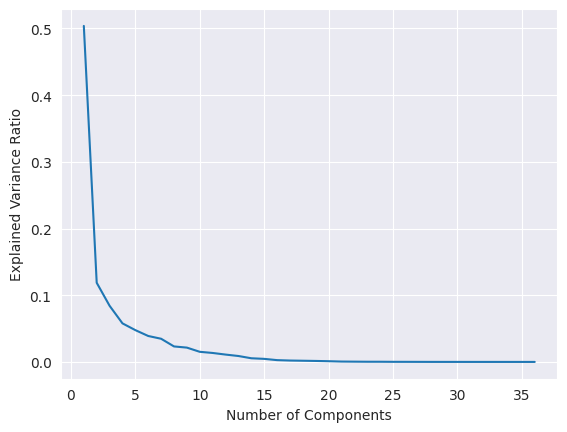

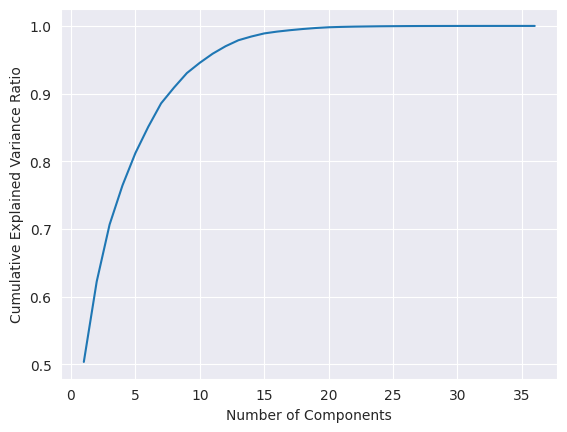

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(df)  # X is your data
explained_var_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

cum_var_ratio = np.cumsum(explained_var_ratio)
plt.plot(range(1, len(cum_var_ratio) + 1), cum_var_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()


In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_components = 5
columns_to_keep = ['year', 'confID', label]
df_to_keep = pd.DataFrame(df[columns_to_keep])

df.drop(columns_to_keep, axis=1, inplace=True)

custom_column_names = [f'PC{i + 1}' for i in range(n_components)]  # Create custom column names

#Assuming 'X' is your data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

pca = PCA(n_components=n_components)  # Choose the number of components you want
X_pca = pca.fit_transform(X_scaled)

df_result = pd.DataFrame(data=X_pca, columns=custom_column_names)

print(df_to_keep['year'].isna().sum())

df_result['year'] = df_to_keep['year'].reset_index(drop=True)
df_result['confID'] = df_to_keep['confID'].reset_index(drop=True)
df_result[label] = df_to_keep[label].reset_index(drop=True)

df = df_result
# X_pca now contains the reduced-dimensional representation of your data
print(df['year'].isna().sum())

0
0


/tmp/ipykernel_20624/1667478322.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns_to_keep, axis=1, inplace=True)


In [12]:
print(df.columns)
print(df.isna().sum())

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'year', 'confID', 'playoff'], dtype='object')
PC1        0
PC2        0
PC3        0
PC4        0
PC5        0
year       0
confID     0
playoff    0
dtype: int64


In [13]:
# corr_matrix = df.corr()
# fig = plt.figure(figsize=(30,30), dpi = 480)
# sn.heatmap(df.corr(), annot = True, fmt = '.2f')
# plt.show()

In [14]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

clf = DecisionTreeClassifier()
mlp = MLPClassifier()
svm = SVC(probability=True, kernel="linear")
bagging = BaggingClassifier()
ada_boost = AdaBoostClassifier()
gradient_boosting = GradientBoostingClassifier()
random_forest = RandomForestClassifier()

mlp_param_grid = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.1, 0.5],
    'learning_rate': ['constant', 'adaptive'],
    'batch_size': [32],
}

clf_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

rlf_param_grid = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}

gdb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 10, 20, 30, 40, 50],
}

bagging_param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'max_samples': [0.5, 0.75, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
}

ada_boost_param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 500],
    'learning_rate': [0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R'],
}

gradient_boosting_param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'subsample': [0.5, 0.75, 1.0],
    'loss': ['deviance', 'exponential'],
}

random_forest_param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 500],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
}

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, \
    roc_curve
import seaborn as sns


def confusion_matrix_plot(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        xticklabels=['No', 'Yes'],
        yticklabels=['No', 'Yes']
    )
    plt.ylabel("Prediction", fontsize=13)
    plt.xlabel("Actual", fontsize=13)
    plt.title("Confusion Matrix", fontsize=14)
    plt.show()


def roc_curve_plot(y_test, y_prob):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')
    plt.show()


def model_score(y_test, y_pred, y_prob):
    print("a", y_prob)
    print("b", y_pred)
    confusion_matrix_plot(y_test, y_pred)
    roc_curve_plot(y_test, y_prob)

    print(f"AUC: {round(roc_auc_score(y_test, y_prob) * 100, 2)}%")
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred) * 100, 2)}%")
    print(f"Precision: {round(precision_score(y_test, y_pred) * 100, 2)}%")
    print(f"Recall: {round(recall_score(y_test, y_pred) * 100, 2)}%")
    print(f"F1: {round(f1_score(y_test, y_pred) * 100, 2)}%")

/tmp/ipykernel_20624/189260604.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.drop(['confID'], axis=1, inplace=True)
/tmp/ipykernel_20624/189260604.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.drop(['confID'], axis=1, inplace=True)
/tmp/ipykernel_20624/189260604.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sampleWeight'] = data['year'].apply

{'activation': 'relu', 'alpha': 0.1, 'batch_size': 32, 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


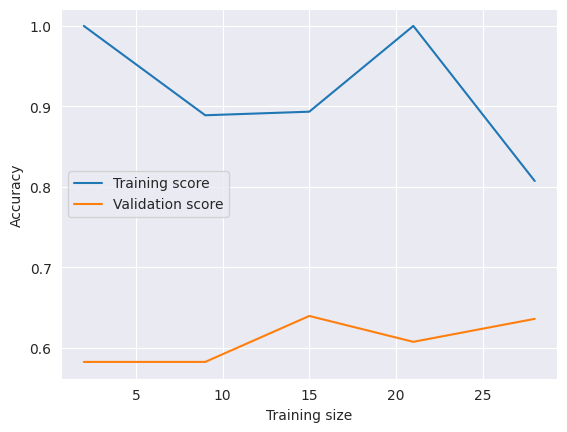

/tmp/ipykernel_20624/189260604.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sampleWeight'] = data['year'].apply(lambda year_x: 2 ** (year - year_x - 1) if year > year_x else 1)
/tmp/ipykernel_20624/189260604.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['year'], axis=1, inplace=True)
/tmp/ipykernel_20624/189260604.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

{'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 32, 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'sgd', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


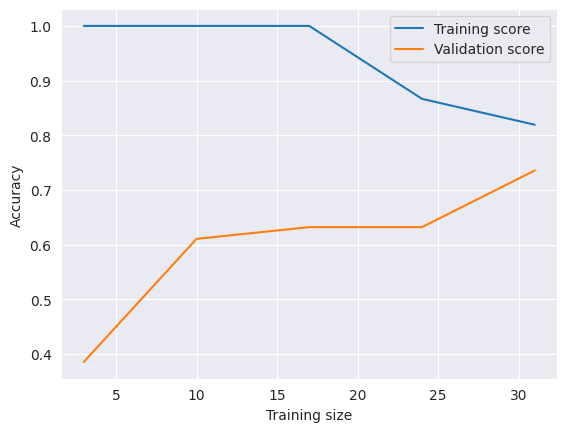

a [0.97270081 0.11611518 0.95657596 0.99768886 0.95258559 0.96219441
 0.6273317  0.87104121 0.39638882 0.60467304 0.8087003  0.93877917
 0.88207559]
b [1 0 1 1 1 1 1 1 0 1 1 1 1]


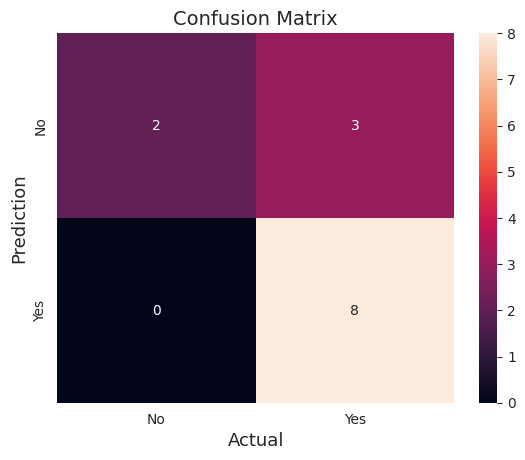

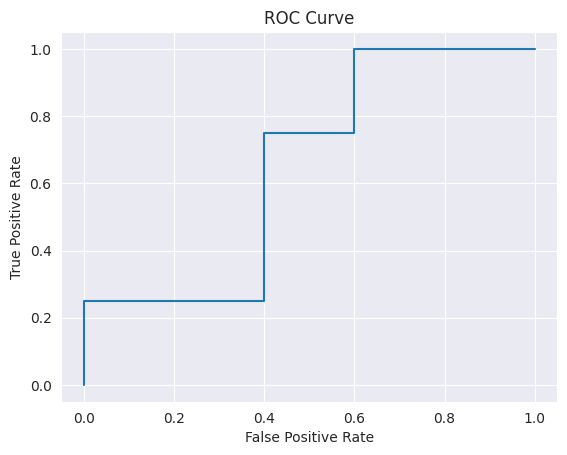

AUC: 65.0%
Accuracy: 76.92%
Precision: 72.73%
Recall: 100.0%
F1: 84.21%


([8], [0.7692307692307693])

In [16]:
from sklearn.model_selection import learning_curve


def split_data(df):
    return df[df['confID'] == 0], df[df['confID'] == 1]


def train_model_validation(year, model, data, label, param_grid):
    data['sampleWeight'] = data['year'].apply(lambda year_x: 2 ** (year - year_x - 1) if year > year_x else 1)
    train_data = data[data["year"] < year]
    test_data = data[data["year"] == year]

    train_data.drop(['year'], axis=1, inplace=True)
    test_data.drop(['year'], axis=1, inplace=True)

    X_train, X_val, y_train, y_val = train_test_split(train_data.drop([label], axis=1),
                                                      train_data[label], test_size=0.3)

    X_test, y_test = test_data.drop([label, 'sampleWeight'], axis=1), test_data[label]
    sample_weight = X_train['sampleWeight']
    model.fit(X_train.drop(['sampleWeight'], axis=1), y_train)
    grid_search = GridSearchCV(model, param_grid, cv=None)
    grid_search.fit(X_val, y_val)

    sample_weight = train_data["sampleWeight"]
    model.set_params(**grid_search.best_params_)

    model.fit(train_data.drop([label, "sampleWeight"], axis=1), train_data[label])

    train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=None)

    print(model.get_params())

    if year == 8:
        plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
        plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation score')
        plt.xlabel('Training size')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    return y_test, y_pred, y_prob


def train_evaluate_decision_tree_graph(model, data, param_grid):
    accuracy_scores = []
    years_tested = []

    data = data.sort_values(by="year")
    data1, data2 = df[df['confID'] == 0], df[df['confID'] == 1]

    data1.drop(['confID'], axis=1, inplace=True)
    data2.drop(['confID'], axis=1, inplace=True)

    year = 8

    y_test1, y_pred1, y_prob1 = train_model_validation(year, model, data1, label, param_grid)
    y_test2, y_pred2, y_prob2 = train_model_validation(year, model, data2, label, param_grid)

    y_test = np.concatenate((y_test1, y_test2))
    y_pred = np.concatenate((y_pred1, y_pred2))
    y_prob = np.concatenate((y_prob1[:, 1], y_prob2[:, 1]))

    if year == 8:
        model_score(y_test, y_pred, y_prob)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    years_tested.append(year)

    return years_tested, accuracy_scores


train_evaluate_decision_tree_graph(mlp, df, mlp_param_grid)

 Model Score

In [17]:
coeff_log = lr.coef_
importance_log = coeff_log[0]
abs_importance_log = abs(importance_log)
importance_list_log = list(zip(df.columns, importance_log, abs_importance_log))
importance_list_log.sort(key=lambda x: x[2], reverse=True)
for i in range(len(importance_list_log)):
    print(importance_list_log[i][1])
    if importance_list_log[i][1] < 0:
        df.drop(importance_list_log[i][0], axis=1, inplace=True)

train_evaluate_decision_tree_graph(lr, df, lr_param_grid)



AttributeError: 'LogisticRegression' object has no attribute 'coef_'